In [1]:
%cd ../..

c:\Boyko Boev\Stock-Market-Prediction\src


In [2]:
import pandas as pd
import numpy as np

from cnn_model import build_model, train_model, save_cnn_model, load_cnn_model
from models.cnn_v3.cnn_normalize import get_cnn_data, getImagesDataset
from utils.chart import config_chart, plot_model_performance, plot_scatter_data, plot_distribution_data, plot_direction_comparison
from constants import SP500_TICKER, NASDAQ_TICKER, DJI_TICKER
# import tensorflow as tf


---

## For **build_model** function

In [3]:
model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 253, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 252, 250, 16)        │           6,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 250, 247, 8)         │           1,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 494000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │      15,808,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,817,469 (60.34 MB)

 Trainable params: 15,817,469 (60.34 MB)

 Non-trainable params: 0 (0.00 B)

---

## For **train_model** function

In [4]:
# nasdaq_train, nasdaq_test, nasdaq_predict= get_cnn_data(NASDAQ_TICKER)
train, test, predict = get_cnn_data(NASDAQ_TICKER)


print("Train data:")
print(train)

print("Test data:")
print(test)

print("Predict data:")
print(predict)

Train data:
<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test data:
<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Predict data:
<_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [5]:
# plt = config_chart('Model Data')
# plt.plot(y_dates_train[:, 0], y_train[:, 0])
# plt.plot(y_dates_test[:, 0], y_test[:, 0])
# plt.plot(y_dates_predict[:, 0], y_predict[:, 0])
# plt.legend(['Train', 'Test','Predict'])

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.2173 - loss: 18.7164
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.4225 - loss: 2.6639
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.5731 - loss: 0.9528
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.4870 - loss: 1.3067
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - accuracy: 0.4155 - loss: 1.3399


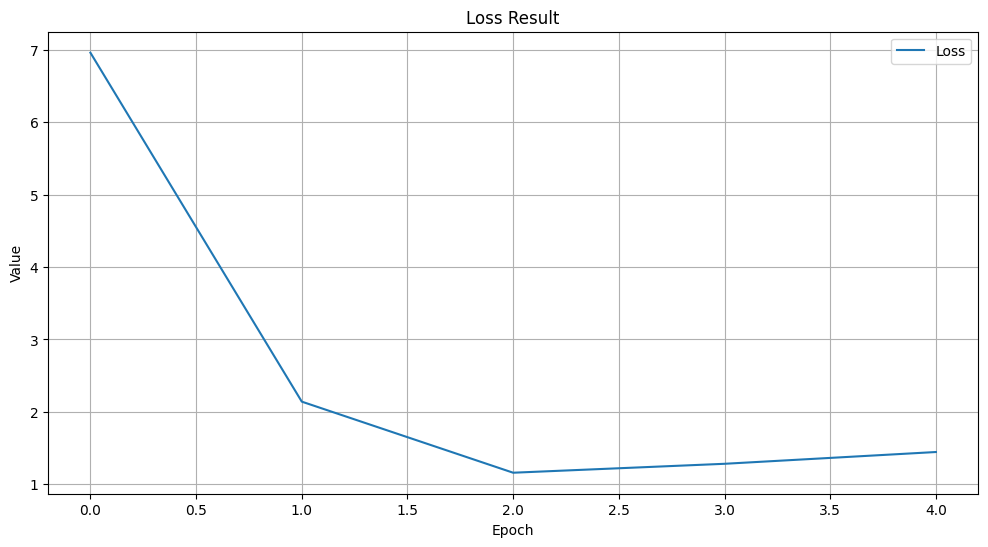

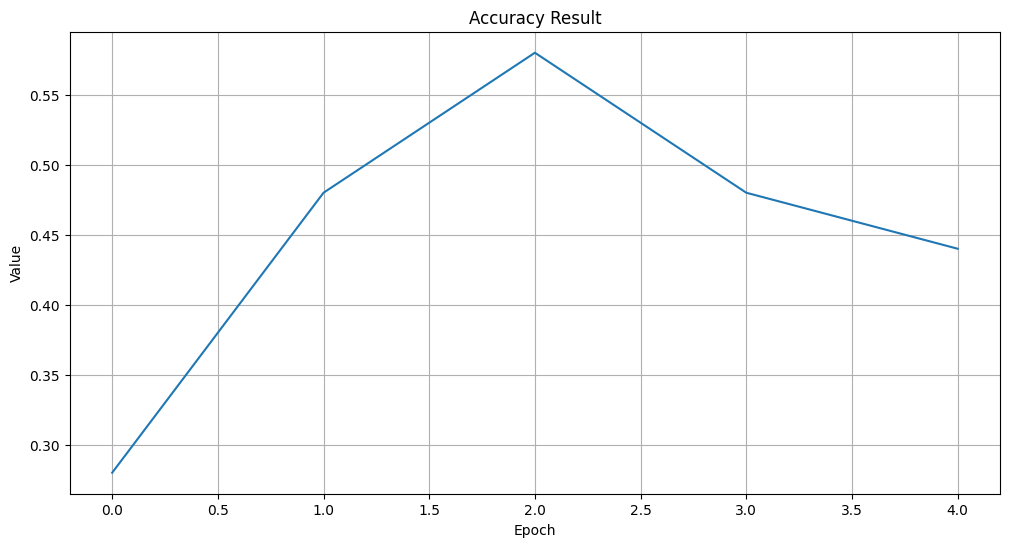

Train result:
Test result:


In [6]:
model, fit_result, evaluate_result = train_model(train, test) 

plot_model_performance(fit_result)
# plot_model_performance(evaluate_result)

print("Train result:")
print(fit_result)

print("Test result:")
print(evaluate_result)

save_cnn_model(model)

In [7]:
latest_train_metrics = [value[-1] for key, value in fit_result.history.items()]

print("Train result:")
print("accuracy, loss, precision, recall")
print(latest_train_metrics)

print("Test result:")
print("loss, accuracy, precision, recall")
print(evaluate_result)

Train result:
accuracy, loss, precision, recall
[0.4399999976158142, 1.4449102878570557]
Test result:
loss, accuracy, precision, recall


In [8]:
model = load_cnn_model()

In [9]:
predictions_train = model.predict(train)

print(predictions_train)

# plot_scatter_data(y_train, predictions_train)
# plot_direction_comparison(y_train, predictions_train)

693/693 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step
[[0.3908426  0.00853857 0.00303668 0.14390662 0.4536755 ]
 [0.00688283 0.5951922  0.0223465  0.00439165 0.3711868 ]
 [0.02465747 0.47925755 0.05893084 0.01413553 0.42301852]
 ...
 [0.16096556 0.01786832 0.02843244 0.25997725 0.53275645]
 [0.26728806 0.00521682 0.00069433 0.03468306 0.69211775]
 [0.13949487 0.00645705 0.00311044 0.29664966 0.5542879 ]]


In [10]:
predictions_test = model.predict(test)

print(predictions_train)

# plot_scatter_data(y_test, predictions_test)
# plot_direction_comparison(y_test, predictions_test)


198/198 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step
[[0.3908426  0.00853857 0.00303668 0.14390662 0.4536755 ]
 [0.00688283 0.5951922  0.0223465  0.00439165 0.3711868 ]
 [0.02465747 0.47925755 0.05893084 0.01413553 0.42301852]
 ...
 [0.16096556 0.01786832 0.02843244 0.25997725 0.53275645]
 [0.26728806 0.00521682 0.00069433 0.03468306 0.69211775]
 [0.13949487 0.00645705 0.00311044 0.29664966 0.5542879 ]]


In [11]:
predictions = model.predict(predict)

# print(predictions)

predicted_classes = np.argmax(predictions, axis=1)
print("Predicted classes:", predicted_classes)
# plot_scatter_data(y_predict, predictions)
# plot_direction_comparison(y_predict, predictions)

actual_classes = []

# Iterate over the dataset to extract the actual class labels
for _, labels in predict:
    actual_classes.extend(labels.numpy())

# Convert to numpy array for comparison
actual_classes = np.array(actual_classes)

print(actual_classes)

# Now, you can compare 'actual_classes' with 'predicted_classes'
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(actual_classes, predicted_classes)
print("Accuracy:", accuracy)

99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
Predicted classes: [4 4 4 1 1 3 4 1 3 1 4 4 4 3 3 1 4 4 4 3 3 1 4 4 4 1 4 3 4 4 1 1 4 4 4 1 3
 1 4 4 3 4 1 4 4 3 4 4 4 3 3 4 4 4 1 4 4 3 3 4 3 4 1 3 4 4 4 1 4 4 3 4 1 3
 1 4 4 1 4 4 1 4 4 4 4 3 1 4 4 4 1 3 4 4 4 3 3 4 4]
[4 3 2 4 2 3 3 1 1 2 2 4 3 4 3 4 4 1 1 3 1 4 4 2 3 4 2 4 0 4 1 3 1 4 4 1 1
 1 3 1 3 4 2 4 4 0 0 1 4 3 4 4 4 4 4 3 0 1 4 0 1 3 1 1 0 1 1 4 1 4 0 4 1 4
 1 0 0 4 0 4 2 1 4 1 4 4 4 4 1 1 4 1 3 4 0 1 3 1 0]
Accuracy: 0.3434343434343434
